In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from sklearn.ensemble import ExtraTreesRegressor
import joblib
import numpy as np
from windrose import WindroseAxes
import datetime
import WinFunctB7 as WFB7

In [2]:
#load wind turbine model

filename = r'C:\Users\M\Desktop\images\data science\wind\Wind_Turbine_Nordex.sav'
load_model = joblib.load(filename)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [3]:
markers={'WithoutWind':'gray','Inside':'green','Outside':'yellow','OutOfService':'red'}
units_measure={'ActPower':'KW',
               'WindSpd':'m/s',
               'ThePower':'kWh',
               'WinDir':'º'}
cutin=3.5

In [4]:
turbine=pd.read_csv(r"C:\Datasets-base\Datasets\Scada\T1.csv")
if turbine.isnull().sum().sum()==0:
    print("No null values")
else:
    print("Atention - Null Values!!!!!")

No null values


In [5]:
dfTurbine=turbine.copy()
dfTurbine['Date/Time']=pd.to_datetime(dfTurbine['Date/Time'], format='%d %m %Y %H:%M')
dfTurbine.rename(columns={'Date/Time':'Date',
                          'LV ActivePower (kW)':'ActPower',
                          'Wind Speed (m/s)':'WindSpd',
                          'Theoretical_Power_Curve (KWh)':'ThePower',
                          'Wind Direction (°)':'WindDir'},inplace=True)
dfTurbine['Day']= dfTurbine['Date'].dt.day
dfTurbine['Month']= dfTurbine['Date'].dt.month
dfTurbine['Year']= dfTurbine['Date'].dt.year
dfTurbine['Hour']= dfTurbine['Date'].dt.hour
dfTurbine['Minute']= dfTurbine['Date'].dt.minute
dfTurbine.sort_values(['Year','Month','Day','Hour','Minute'], ascending=True)
dfTurbine['CumRealPower'] = dfTurbine['ActPower'].cumsum()
dfTurbine['CumTheoPower'] = dfTurbine['ThePower'].cumsum()

In [6]:
WFB7.labelStatusGen(dfTurbine,CutIn=cutin,CutinPower=load_model.predict([[cutin]]))
stat=WFB7.StatVal(dfTurbine)        #statistic data

print(dfTurbine.columns)

Index(['Date', 'ActPower', 'WindSpd', 'ThePower', 'WindDir', 'Day', 'Month',
       'Year', 'Hour', 'Minute', 'CumRealPower', 'CumTheoPower', 'InsideLim'],
      dtype='object')


In [7]:

for j in range(1):
    daysdic={'Wind':[stat['Inside'][j]+stat['Outside'][j]+stat['OutOfService'][j]],
         'WhithoutWin':[stat['WhithoutWin'][j]]}
    statWin={'Inside_Range':[stat['Inside'][j]],
             'Outside_Range':[stat['Outside'][j]],
             'Out_Of_Service':[stat['OutOfService'][j]]}

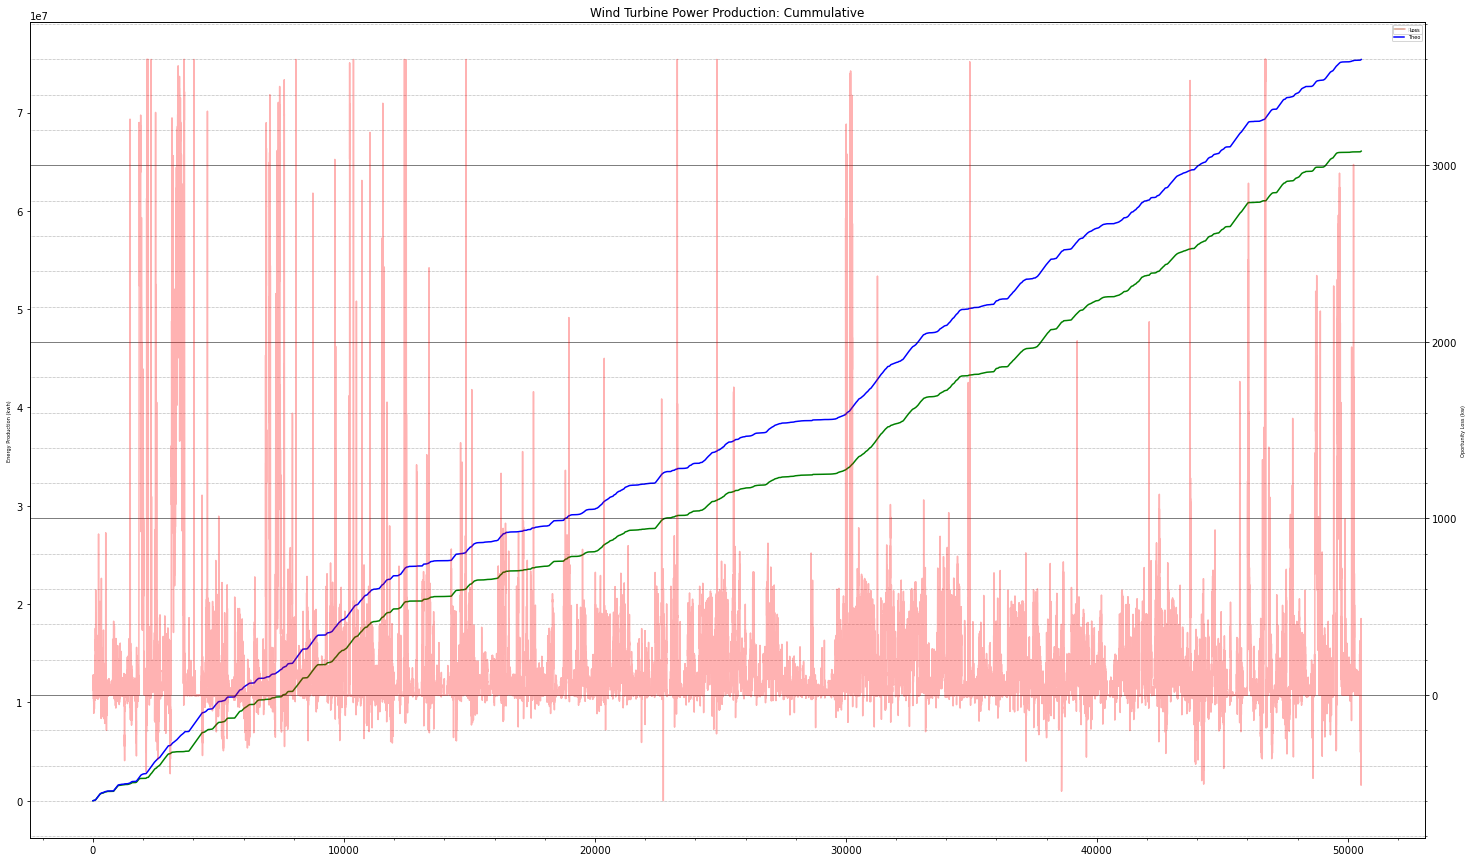

In [8]:

WFB7.plotdata(dfTurbine,Y1='CumRealPower',Y2='CumTheoPower',Y3='ActPower',Y4='ThePower')


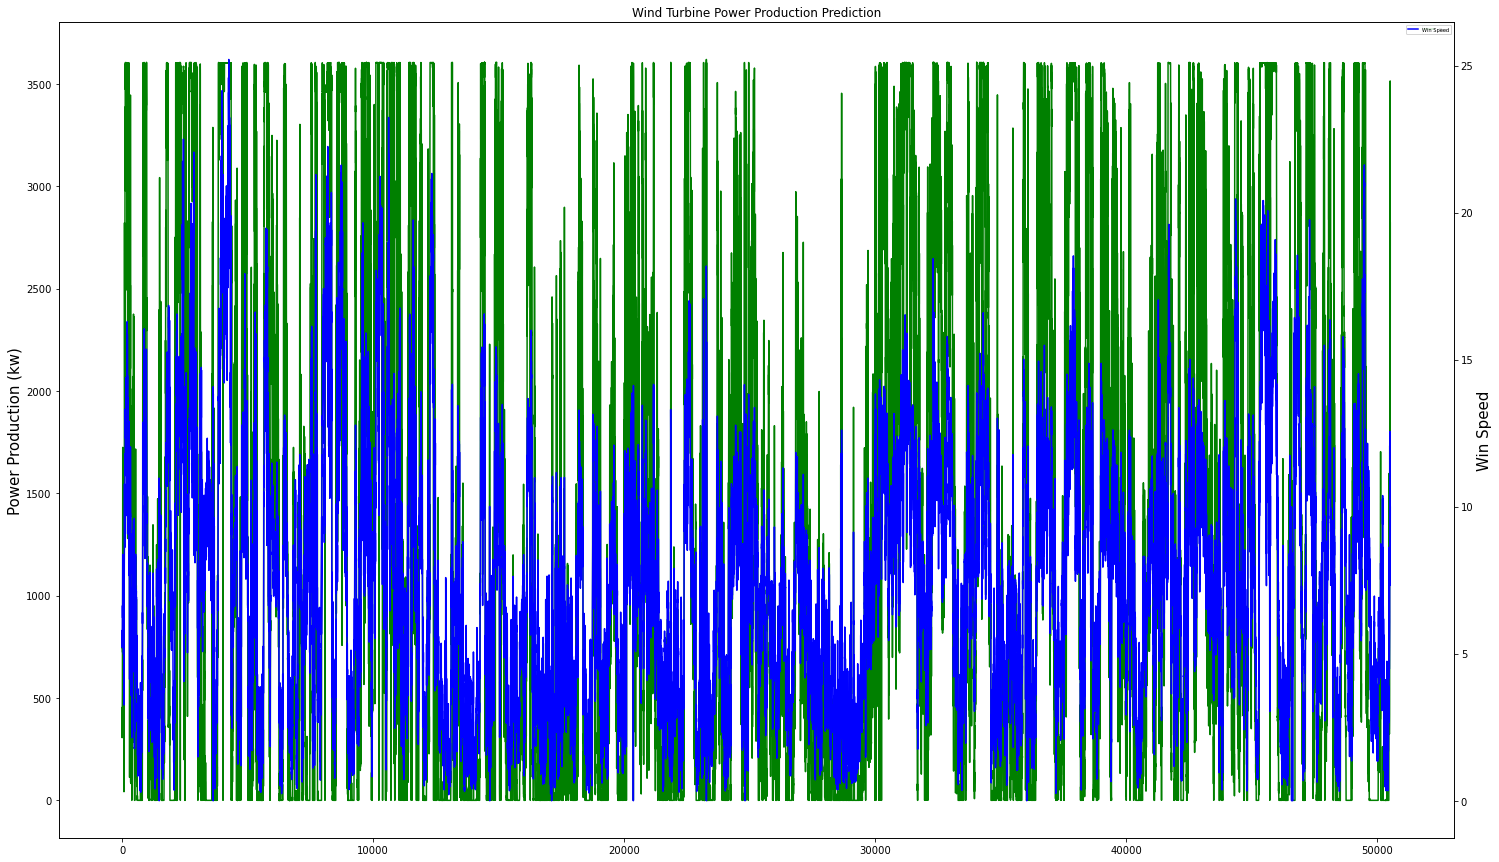

In [9]:

WFB7.plotdata1(dfTurbine)


No handles with labels found to put in legend.


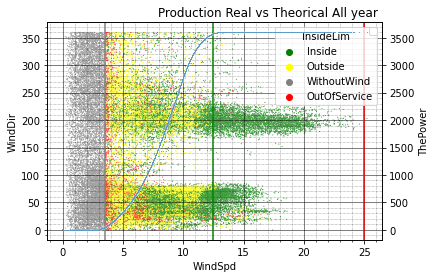

In [10]:
WFB7.PlotGen(dfTurbine,markers,x='WindSpd',y='WindDir',y2='ThePower',hue='InsideLim',title="Production Real vs Theorical All year ",CutIn=cutin,show=1)


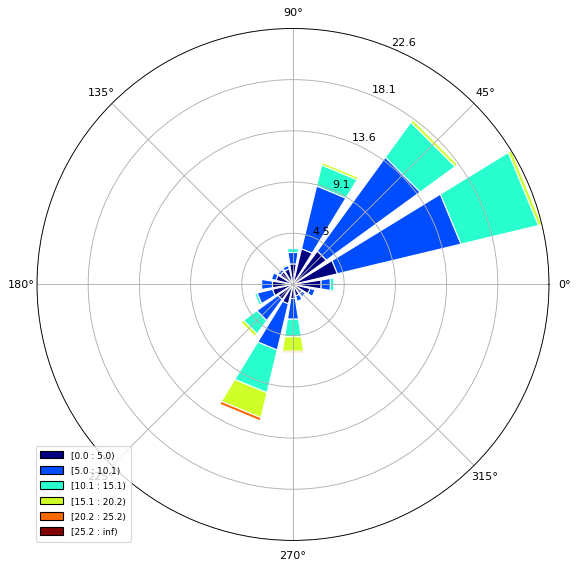

In [11]:
WFB7.plotWindrose(dfTurbine)


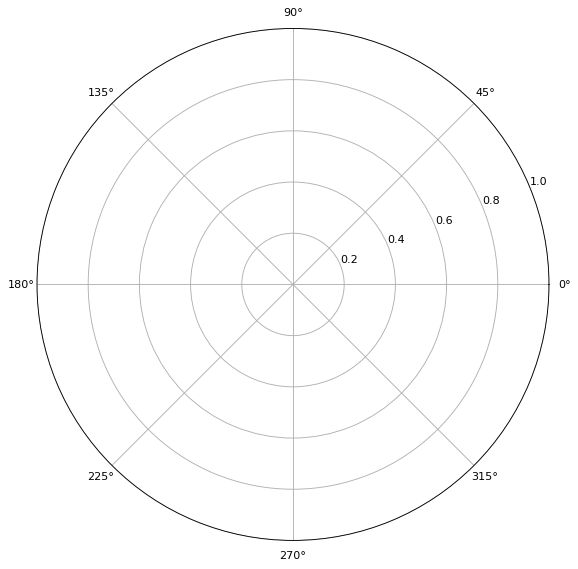

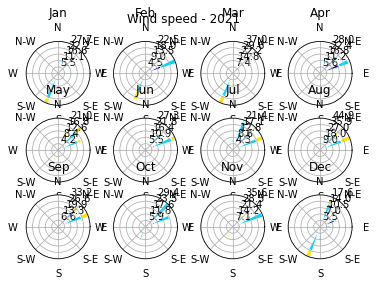

In [12]:
WFB7.plotPowerWin(dfTurbine,month1='01')


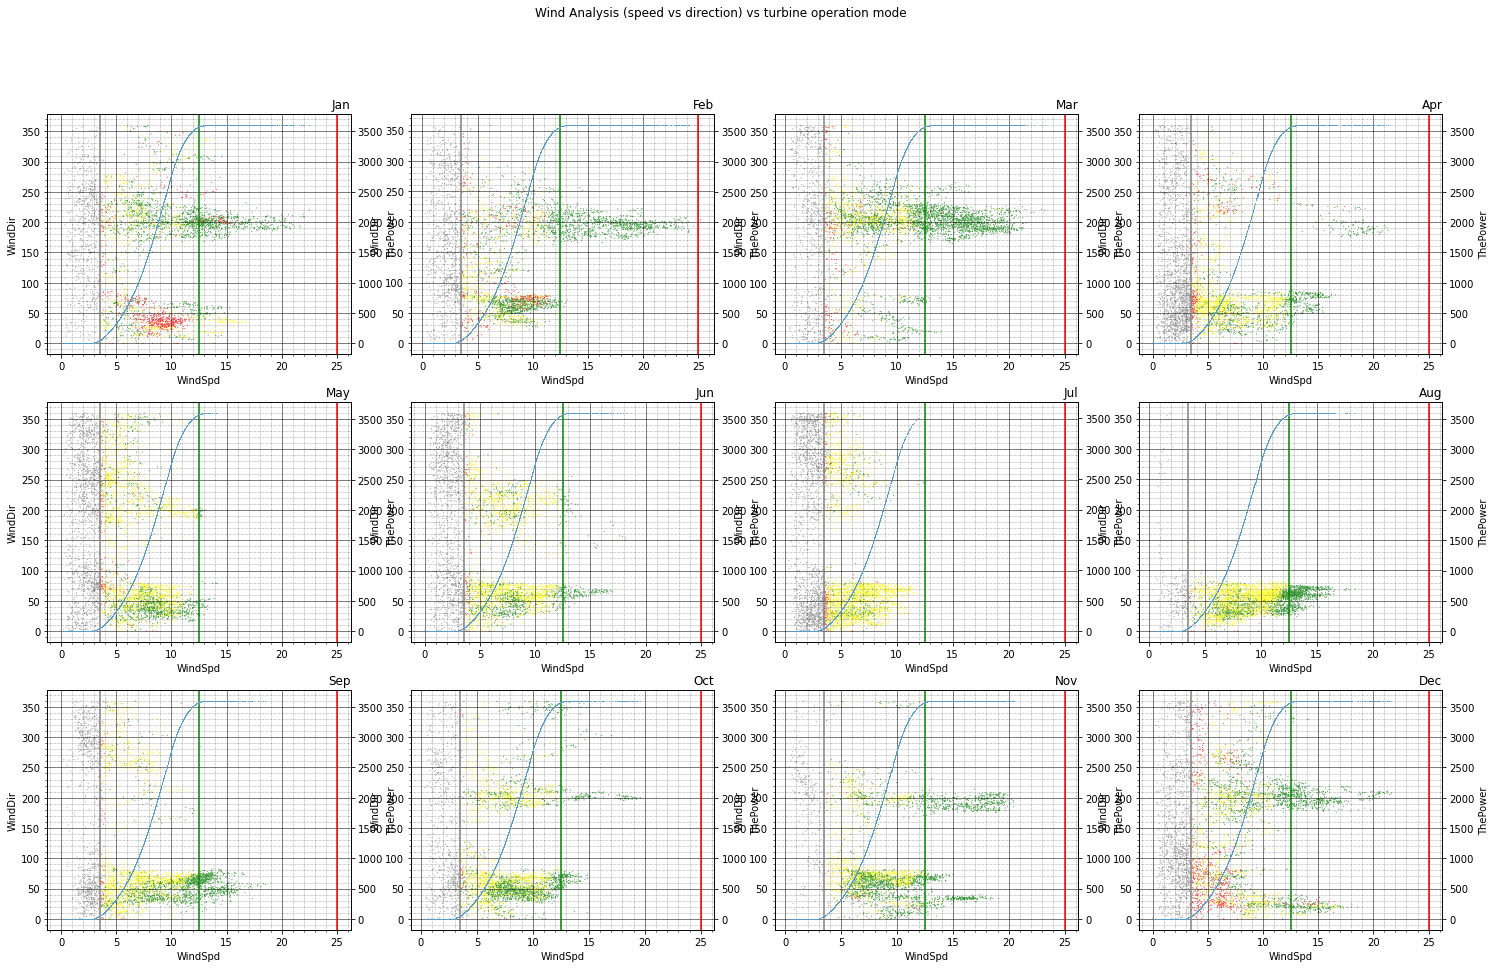

In [13]:
WFB7.PlotMonth(dfTurbine,markers,CutIn=cutin)


No handles with labels found to put in legend.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


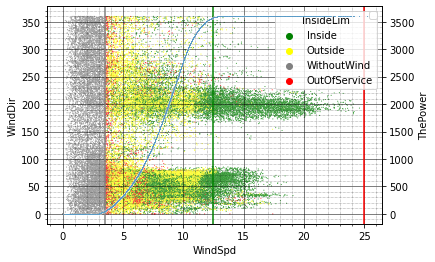

In [14]:
WFB7.PlotGen(dfTurbine,markers,show=1,CutIn=cutin)


[40635, 9895]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-

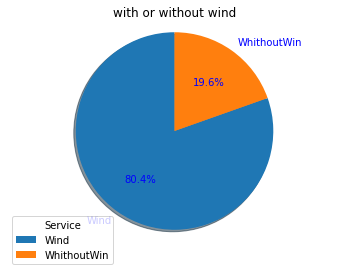

In [15]:
WFB7.pltpizza(daysdic,title="with or without wind",time='m')    


[18143, 19620, 2872]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 

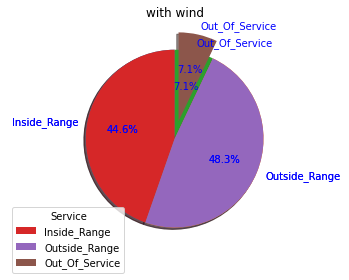

In [16]:
WFB7.pltpizza(statWin,title="with wind",time='m',explode=1)


[18143, 19620, 2872]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 

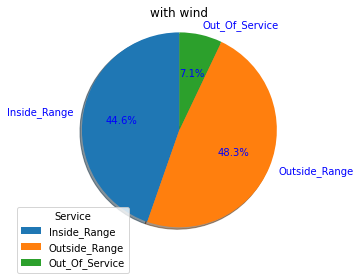

In [17]:
WFB7.pltpizza(statWin,title="with wind",time='m')


[3225, 592]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-ca

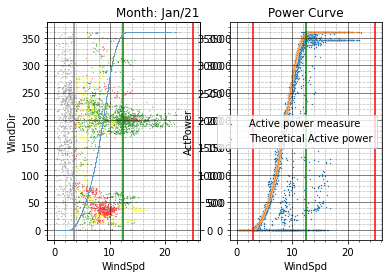

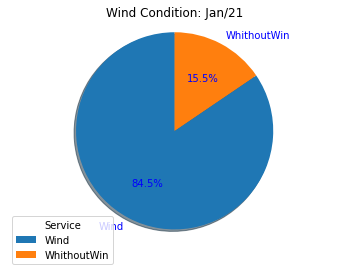

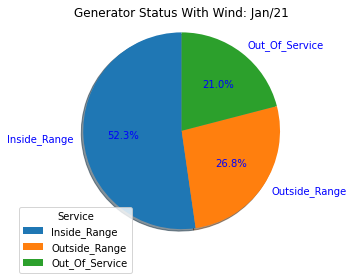

In [18]:
WFB7.PlotMonthPiz(dfTurbine,markers,CutIn=cutin)


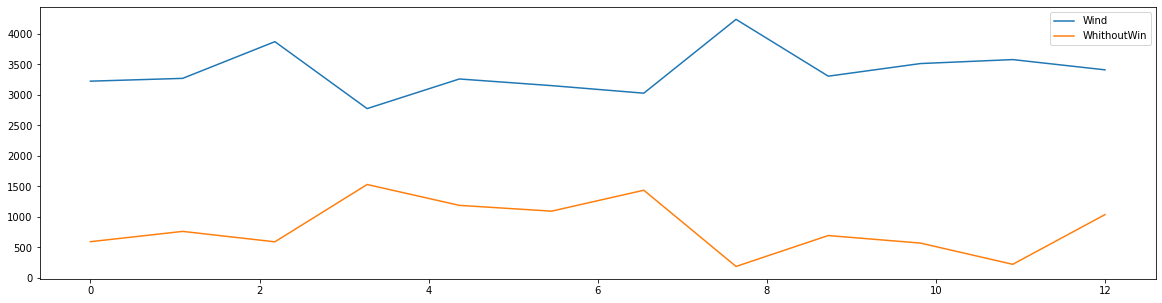

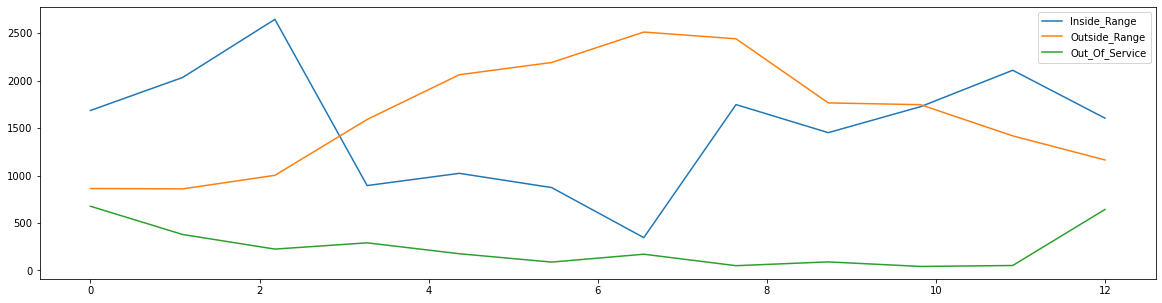

In [19]:
WFB7.Status(dfTurbine)